In [29]:
from __future__ import annotations
import pickle,gzip,math,os,time,shutil,torch
import matplotlib as mpl
import logging
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc
from torch.utils.data import default_collate
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import tensor,nn,optim
import torchvision.transforms.functional as TF
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

# !pip install datasets
from datasets import load_dataset,load_dataset_builder

# Hugging Face Datasets
Dataset names at: https://huggingface.co/datasets

In [30]:
name = 'fashion_mnist'
ds_builder = load_dataset_builder(name)
ds_builder.info.description

"Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of\n60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,\nassociated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in\nreplacement for the original MNIST dataset for benchmarking machine learning algorithms.\nIt shares the same image size and structure of training and testing splits.\n"

In [31]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [32]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296607, num_examples=60000, shard_lengths=None, dataset_name='fashion_mnist'),
 'test': SplitInfo(name='test', num_bytes=5233810, num_examples=10000, shard_lengths=None, dataset_name='fashion_mnist')}

In [33]:
dataset = load_dataset(name) # load in cache

In [34]:
dataset, type(dataset)

(DatasetDict({
     train: Dataset({
         features: ['image', 'label'],
         num_rows: 60000
     })
     test: Dataset({
         features: ['image', 'label'],
         num_rows: 10000
     })
 }),
 datasets.dataset_dict.DatasetDict)

In [35]:
train_dataset, test_dataset = dataset['train'], dataset['test']
train_dataset[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [36]:
x, y = 'image', 'label'
train_dataset[0][x]

In [37]:
train_dataset[0][y] 

9

In [38]:
featy = train_dataset.features[y]; featy, type(featy)

(ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None),
 datasets.features.features.ClassLabel)

In [13]:
featy.int2str(train_dataset[y])

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top',
 'Pullover',
 'Sneaker',
 'Pullover',
 'Sandal',
 'Sandal',
 'T - shirt / top',
 'Ankle boot',
 'Sandal',
 'Sandal',
 'Sneaker',
 'Ankle boot',
 'Trouser',
 'T - shirt / top',
 'Shirt',
 'Coat',
 'Dress',
 'Trouser',
 'Coat',
 'Bag',
 'Coat',
 'Dress',
 'T - shirt / top',
 'Pullover',
 'Coat',
 'Coat',
 'Sandal',
 'Dress',
 'Shirt',
 'Shirt',
 'T - shirt / top',
 'Bag',
 'Sandal',
 'Pullover',
 'Trouser',
 'Shirt',
 'Shirt',
 'Sneaker',
 'Ankle boot',
 'Sandal',
 'Ankle boot',
 'Pullover',
 'Sneaker',
 'Dress',
 'T - shirt / top',
 'Dress',
 'Dress',
 'Dress',
 'Sneaker',
 'Pullover',
 'Pullover',
 'Shirt',
 'Shirt',
 'Bag',
 'Dress',
 'Dress',
 'Sandal',
 'T - shirt / top',
 'Sandal',
 'Sandal',
 'T - shirt / top',
 'Pullover',
 'T - shirt / top',
 'T - shirt / top',
 'Coat',
 'Trouser',
 'Dress',
 'Trouser',
 'Shirt',
 'Dress',
 'Trouser',
 'Coat',
 'Coat',
 'Shirt',
 'Trouser',
 'Ankle boot',
 'Trou

Now to train a model as we have seen we need:
1) train_ds, valid_ds and respective data loaders
2) model
3) optim

In [27]:
# data loaders:
def collate_fn(batch): # [(xi,yi), (xj,yj), ...]
    
    # potentially you could put all preprocessing code here
    # useful for custom stuff
    
    # collate : f used by DataLoader to create batch from idxs
    return {x:torch.stack([TF.to_tensor(o[x]) for o in batch]),
           y:tensor([o[y] for o in batch])}
    

In [28]:
batch = [train_dataset[i] for i in range(5)]
for o in batch:
    print(o[x], o[y])

<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x181D5072750> 9
<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x181D668D410> 0
<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x181DCD9A390> 0
<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x181D51319D0> 3
<PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x181D5131B10> 0


In [29]:
collate_fn(batch)

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
      

In [30]:
dataLoader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=16)
batch = next(iter(dataLoader))
batch

{'image': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
    

In [31]:
batch[x].shape, batch[y].shape

(torch.Size([16, 1, 28, 28]), torch.Size([16]))

In [32]:
# an alternative way to apply preprocessing is instead of doing it inside collate_fn, do it in the transforms
def transforms(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]
    return b # this must return "new" data

In [33]:
# now to apply our transform without much work we can:
tds = train_dataset.with_transform(transforms) # same api of a dataset
# the trasform funct will be applied when __getitem__ is called

In [35]:
dataLoader = DataLoader(tds, batch_size=16) 
# no collate cuz pyt knows how to collate dict of tensors
# cuz it applies default_collate (see later) that works with tuples and dicts
b = next(iter(dataLoader))
b[x].shape, b[y].shape

(torch.Size([16, 1, 28, 28]), torch.Size([16]))

In [37]:
# to have the transforms(b) func in place we can:

def transformInplace(b): 
    # this is the func I want and this func must also automatically return
    # the modified output, how can I do it?
    b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]
    
    
def inplace(f): # so we have the inplace func transformInplace passed as in
    def _f(b): # create a new func
        f(b) # that applies the input func (transformInplace) that acts on its input
        return b # return the new input
    return _f # return the function that modifies b inplace

trasform_ = inplace(transformInplace)

r = train_dataset.with_transform(trasform_)
r[0][x].shape, r[1][y]

(torch.Size([784]), 0)

In [39]:
# we can replace trasform_ = inplace(transformInplace) with:

@inplace # name of the decorating func
def transform_(b): 
    b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]
    
# The @ before a func says: take the func that I'm going to def here below,
# and pass it as input to the @func and replace the output of @func to the def func

In [40]:
tds = train_dataset.with_transform(trasform_)
tds[0][x].shape, tds[1][y]

(torch.Size([784]), 0)

In [44]:
# so now we have many pieces to make stuff automatic. To make stuff automatic 
# we are going to use itemgetter:
# example:
d = dict(a=1, b=2, c=3)
ig = itemgetter('a', 'c') # returns a func that gets vals form dict
ig(d)

(1, 3)

In [45]:
# this is a small digression to show how py differs from C++
# this works with dictionaries, or whatever looks like a dictionary eg:
class D:
    def __getitem__(self, k): 
        return 1 if k=='a' else 2 if k=='b' else 3
    
d = D()
ig(d)

(1, 3)

In [48]:
# pyt has a default collate funct:
batch = dict(a=[1], b=[2]), dict(a=[3], b=[4])
print(default_collate(batch))

# takes 2 (or more) dicts -> returns {k:k, v: stacks together values for same keys across input dicts}
# gets matching keys -> get their values -> stacks values together
# works also on tuples:

batch = ("a",1), ("b", 2), ("a", 3), ("b", 4)
default_collate(batch)


{'a': [tensor([1, 3])], 'b': [tensor([2, 4])]}


[('a', 'b', 'a', 'b'), tensor([1, 2, 3, 4])]

In [53]:
train_dataset, list(train_dataset.features)

(Dataset({
     features: ['image', 'label'],
     num_rows: 60000
 }),
 ['image', 'label'])

In [54]:
# we can use this default collate to collate a dict such to make it as tuple

def collate_dict(ds): # transform hugging face stuff that is in dict to tuples
    get = itemgetter(*ds.features) # a func that gets items from dict wrt inputs
    def _f(b): # take a batch
        return get(default_collate(b)) # from batch collate  ['image', 'label'] 
    return _f


In [60]:
tds = train_dataset.with_transform(trasform_)
dlf = DataLoader(tds, batch_size=4, collate_fn=collate_dict(tds))
xb, yb = next(iter(dlf))
xb, yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 0, 0, 3]))

# Plotting Images

torch.Size([16, 1, 28, 28])
torch.Size([1, 28, 28])


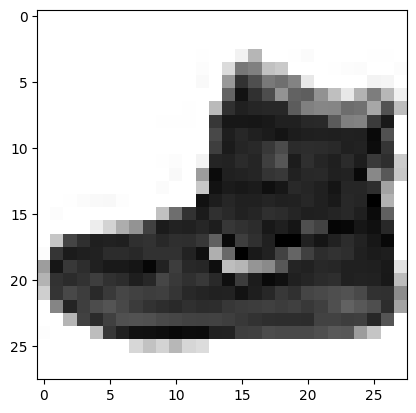

In [78]:
b = next(iter(dataLoader))
print(b[x].shape)
xb = b[x]
img = xb[0]
print(img.shape)
plt.imshow(img.squeeze())

In [79]:
def show_img(im, ax=None, figsize=None, title=None, **kwargs):
    if ax is None:
        _, ax = plt.subplots(figure=figsize)
    ax.imshow(im, **kwargs)
    if title:
        ax.set_title(title)
    ax.axis('off')
    return ax

<Axes: >

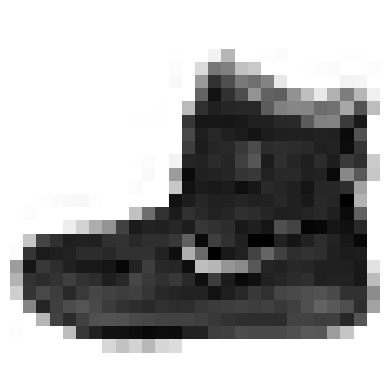

In [83]:
show_img(img.squeeze())

<Axes: >

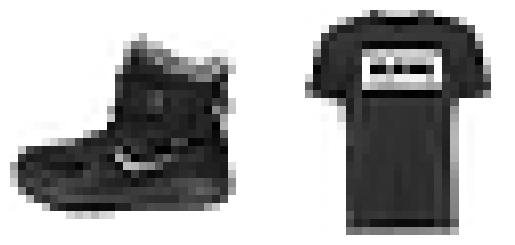

In [85]:
fig, axs = plt.subplots(1,2) # 1 row 2 cols; axs refers the subplot
show_img(xb[0].squeeze(), axs[0])
show_img(xb[1].squeeze(), axs[1])

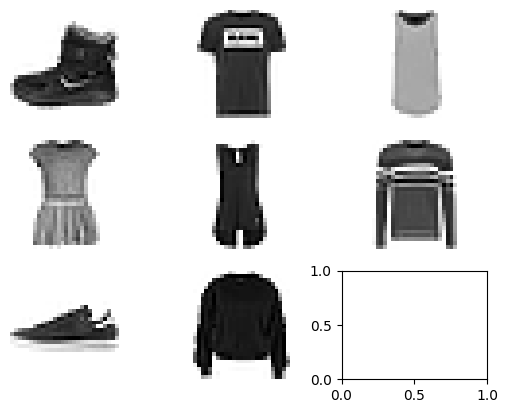

In [88]:
fig, axs = plt.subplots(3,3)
print(axs.flat)
imgs = xb[:8]
for ax, img in zip(axs.flat, imgs):
    show_img(img.squeeze(), ax)